In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import numpy as np

In [19]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


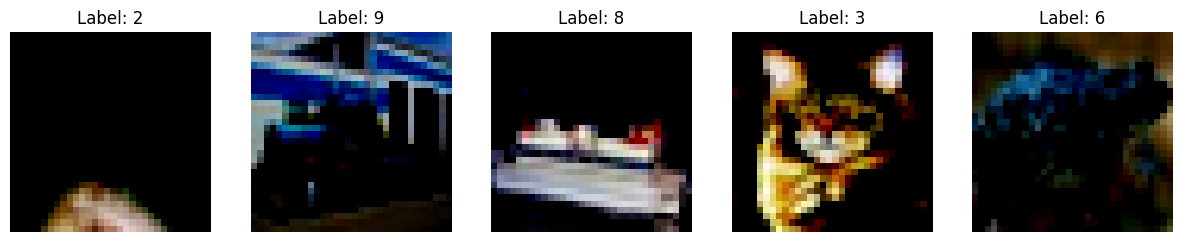

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


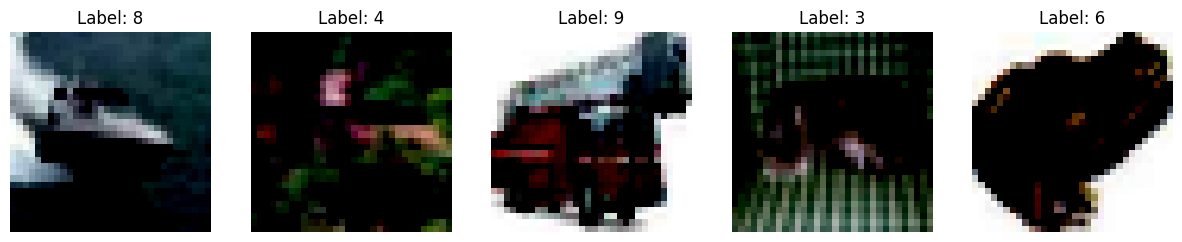

In [21]:
import random

# Function to display random images with labels from the dataset
def display_random_images_with_labels(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Display random images with labels from the training dataset
display_random_images_with_labels(train_dataset)

# Display random images with labels from the test dataset
display_random_images_with_labels(test_dataset)

In [22]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [9]:
# Display sizes of train, test, and validation sets
print(f"Size of the training set: {len(train_dataset)}")
print(f"Size of the validation set: {len(val_dataset)}")
print(f"Size of the test set: {len(test_dataset)}")

Size of the training set: 40000
Size of the validation set: 10000
Size of the test set: 10000


In [23]:
# Move data loaders to GPU if available
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [24]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()  # Record start time for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted_probs = torch.softmax(outputs, 1)
            _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted_probs = torch.softmax(outputs, 1)
                _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        end_time = time.time()  # Record end time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch time

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f} seconds")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs

In [25]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            outputs = model(inputs)
            predicted = torch.argmax(torch.softmax(outputs, 1), dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy

### Variant 3:

Method 1: In this method, a Dropout layer with a specified dropout probability is added as a separate layer within the model's __init__ method. During the forward pass, this dropout layer is then applied before the output layer. ( layer with a dropout probability of 0.5 is added directly).


Adding dropout before fully connected layer






In [26]:
# Define Mini-VGG network with dropout (version 1)
class MiniVGG_dropout_1(nn.Module):
    def __init__(self):
        super(MiniVGG_dropout_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [27]:
from tabulate import tabulate

# Define table headers and data
headers = ["Layer Type", "Window Size", "Number of Filters"]
data = [
    ["Convolutional", "(3x3)", "64"],
    ["Convolutional", "(3x3)", "64"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "128"],
    ["Convolutional", "(3x3)", "128"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "256"],
    ["Convolutional", "(3x3)", "256"],
    ["MaxPool", "(2x2)", "-"],
    ["Fully Connected", "-", "512"],
    ["Dropout", "-", "-"],  # Dropout layer with probability 0.5
    ["Fully Connected", "-", "10"]
]

# Display table for Mini-VGG network with dropout
print(tabulate(data, headers=headers, tablefmt="grid"))

+-----------------+---------------+---------------------+
| Layer Type      | Window Size   | Number of Filters   |
+=================+===============+=====================+
| Convolutional   | (3x3)         | 64                  |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 64                  |
+-----------------+---------------+---------------------+
| MaxPool         | (2x2)         | -                   |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 128                 |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 128                 |
+-----------------+---------------+---------------------+
| MaxPool         | (2x2)         | -                   |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 256                 |
+-----------------+---------------+---------------------+
| Convolutiona

In [28]:
# Initialize MiniVGG_dropout_1 model
model_dropout_1 = MiniVGG_dropout_1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_1.parameters(), lr=0.001)  # Experimenting with lr = 0.001 (before tuning)

# Train MiniVGG_dropout_1 model
train_losses_dropout_1, val_losses_dropout_1, train_accs_dropout_1, val_accs_dropout_1 = train(model_dropout_1, criterion, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 1.5865, Val Loss: 1.3034, Train Acc: 0.4108, Val Acc: 0.5275, Time: 3.35 seconds
Epoch 2/50, Train Loss: 1.0610, Val Loss: 0.8997, Train Acc: 0.6172, Val Acc: 0.6805, Time: 3.21 seconds
Epoch 3/50, Train Loss: 0.8147, Val Loss: 0.7454, Train Acc: 0.7108, Val Acc: 0.7406, Time: 3.16 seconds
Epoch 4/50, Train Loss: 0.6548, Val Loss: 0.7649, Train Acc: 0.7691, Val Acc: 0.7400, Time: 3.27 seconds
Epoch 5/50, Train Loss: 0.5383, Val Loss: 0.6695, Train Acc: 0.8104, Val Acc: 0.7713, Time: 3.35 seconds
Epoch 6/50, Train Loss: 0.4368, Val Loss: 0.6646, Train Acc: 0.8454, Val Acc: 0.7809, Time: 3.23 seconds
Epoch 7/50, Train Loss: 0.3481, Val Loss: 0.7336, Train Acc: 0.8766, Val Acc: 0.7780, Time: 3.14 seconds
Epoch 8/50, Train Loss: 0.2741, Val Loss: 0.7435, Train Acc: 0.9014, Val Acc: 0.7871, Time: 3.21 seconds
Epoch 9/50, Train Loss: 0.2279, Val Loss: 0.8171, Train Acc: 0.9187, Val Acc: 0.7875, Time: 3.15 seconds
Epoch 10/50, Train Loss: 0.1863, Val Loss: 0.8705, Trai

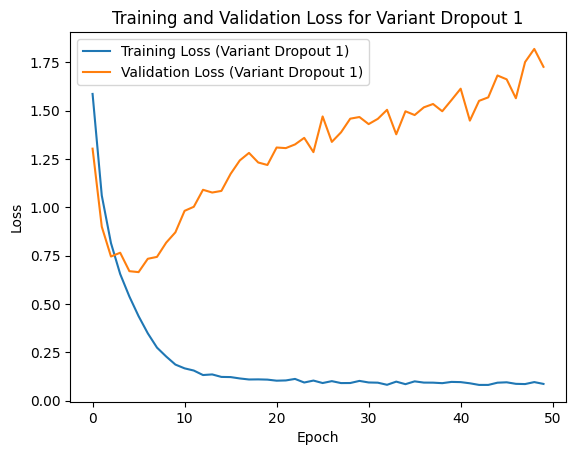

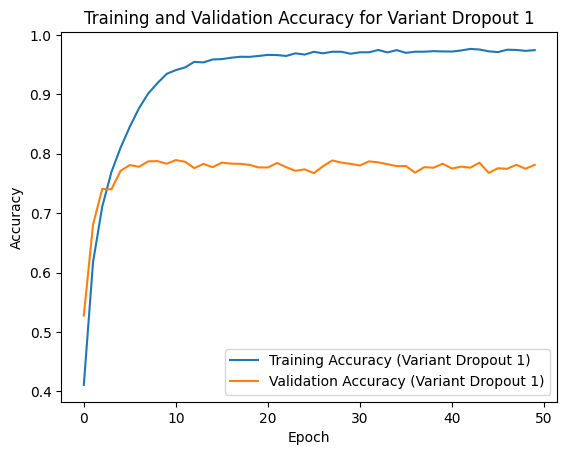

Test Accuracy for MiniVGG Dropout 1 model: 0.7741


In [29]:
# Plot training and validation loss for Variant 1b
plt.plot(train_losses_dropout_1, label='Training Loss (Variant Dropout 1)')
plt.plot(val_losses_dropout_1, label='Validation Loss (Variant Dropout 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 1')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 1b
plt.plot(train_accs_dropout_1, label='Training Accuracy (Variant Dropout 1)')
plt.plot(val_accs_dropout_1, label='Validation Accuracy (Variant Dropout 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 1')
plt.legend()
plt.show()

# Test the Variant Dropout 1 model
test_accuracy_dropout_1 = test(model_dropout_1, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 1 model: {test_accuracy_dropout_1:.4f}")

### Data Augmentation

In [30]:
# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

# Define data loaders
# Move train and validation data loaders to GPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Display the number of samples in the training, validation, and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of validation samples: 10000
Number of testing samples: 10000


### Batch Normalization & Changing the dropout probability to 0.35

In [129]:
import torch
import torch.nn as nn

class MiniVGG_dropout_1_BN(nn.Module):
    def __init__(self):
        super(MiniVGG_dropout_1_BN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.bn4(torch.relu(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.bn5(torch.relu(self.conv5(x)))
        x = self.bn6(torch.relu(self.conv6(x)))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.bn_fc1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Adding L2 Regularization with weight decay of 1e-4

In [40]:
# Initialize MiniVGG model with Batch Normalization and Dropout
model_d1 = MiniVGG_dropout_1_BN().to(device)

# Set dropout probability
model_d1.dropout.p = 0.4

# Define criterion, optimizer, and learning rate with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d1.parameters(), lr=0.001, weight_decay=1e-4) ###Lr0.001 gave pro,osing results

# Train MiniVGG model with Batch Normalization and Dropout with increased epochs
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_d1, criterion, optimizer, train_loader, val_loader, num_epochs=150)

Epoch 1/130, Train Loss: 1.3719, Val Loss: 0.9557, Train Acc: 0.5075, Val Acc: 0.6567, Time: 8.56 seconds
Epoch 2/130, Train Loss: 0.9180, Val Loss: 0.7313, Train Acc: 0.6777, Val Acc: 0.7495, Time: 8.25 seconds
Epoch 3/130, Train Loss: 0.7592, Val Loss: 0.6326, Train Acc: 0.7346, Val Acc: 0.7863, Time: 8.36 seconds
Epoch 4/130, Train Loss: 0.7081, Val Loss: 0.6136, Train Acc: 0.7519, Val Acc: 0.7925, Time: 8.60 seconds
Epoch 5/130, Train Loss: 0.6088, Val Loss: 0.5414, Train Acc: 0.7870, Val Acc: 0.8227, Time: 8.36 seconds
Epoch 6/130, Train Loss: 0.5604, Val Loss: 0.4878, Train Acc: 0.8051, Val Acc: 0.8316, Time: 8.45 seconds
Epoch 7/130, Train Loss: 0.5174, Val Loss: 0.4547, Train Acc: 0.8226, Val Acc: 0.8469, Time: 8.38 seconds
Epoch 8/130, Train Loss: 0.4875, Val Loss: 0.4283, Train Acc: 0.8304, Val Acc: 0.8540, Time: 8.40 seconds
Epoch 9/130, Train Loss: 0.4575, Val Loss: 0.4290, Train Acc: 0.8428, Val Acc: 0.8543, Time: 8.24 seconds
Epoch 10/130, Train Loss: 0.4397, Val Loss: 0.

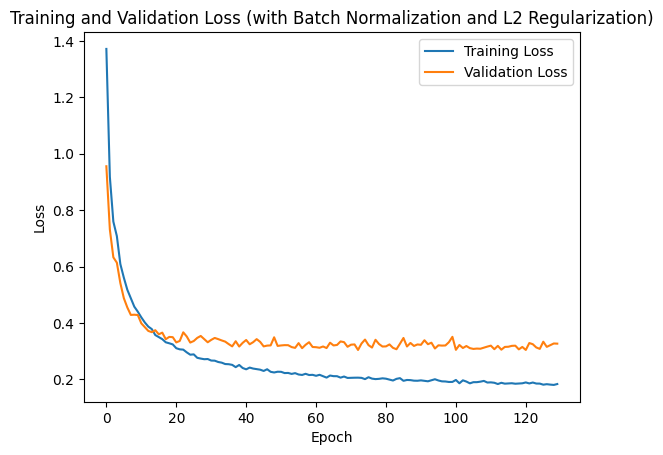

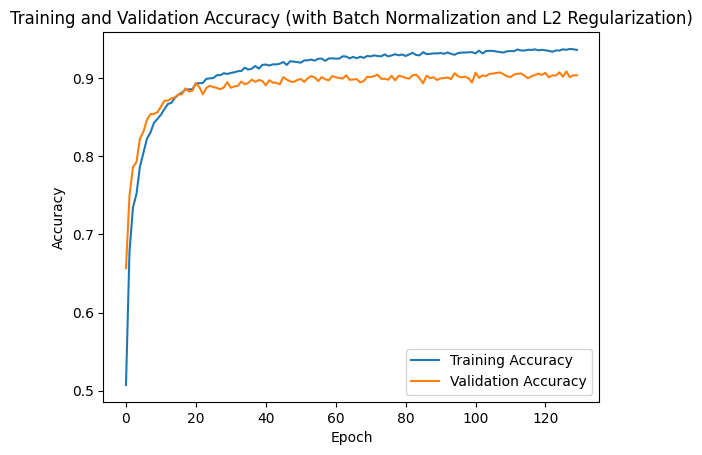

Test Accuracy for MiniVGG_dropout_1_BN model (with Batch Normalization and L2 Regularization): 0.9036


In [41]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_d1, test_loader)
print(f"Test Accuracy for MiniVGG_dropout_1_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Changing the dropout probability to 0.35 - Best Graph

In [44]:
# Initialize MiniVGG model with Batch Normalization and Dropout
model_d1 = MiniVGG_dropout_1_BN().to(device)

# Set dropout probability
model_d1.dropout.p = 0.35

# Define criterion, optimizer, and learning rate with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d1.parameters(), lr=0.001, weight_decay=1e-4) ###Lr0.001 gave pro,osing results

# Train MiniVGG model with Batch Normalization and Dropout with increased epochs
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_d1, criterion, optimizer, train_loader, val_loader, num_epochs=150)

Epoch 1/150, Train Loss: 1.3816, Val Loss: 1.0208, Train Acc: 0.5032, Val Acc: 0.6412, Time: 8.54 seconds
Epoch 2/150, Train Loss: 0.9298, Val Loss: 0.7043, Train Acc: 0.6717, Val Acc: 0.7556, Time: 8.51 seconds
Epoch 3/150, Train Loss: 0.7564, Val Loss: 0.6297, Train Acc: 0.7337, Val Acc: 0.7862, Time: 8.51 seconds
Epoch 4/150, Train Loss: 0.6648, Val Loss: 0.5542, Train Acc: 0.7688, Val Acc: 0.8151, Time: 8.72 seconds
Epoch 5/150, Train Loss: 0.5896, Val Loss: 0.4908, Train Acc: 0.7951, Val Acc: 0.8293, Time: 8.47 seconds
Epoch 6/150, Train Loss: 0.5466, Val Loss: 0.4518, Train Acc: 0.8099, Val Acc: 0.8431, Time: 8.10 seconds
Epoch 7/150, Train Loss: 0.5034, Val Loss: 0.4425, Train Acc: 0.8260, Val Acc: 0.8526, Time: 7.82 seconds
Epoch 8/150, Train Loss: 0.4886, Val Loss: 0.4532, Train Acc: 0.8305, Val Acc: 0.8467, Time: 7.75 seconds
Epoch 9/150, Train Loss: 0.4599, Val Loss: 0.3993, Train Acc: 0.8405, Val Acc: 0.8606, Time: 7.71 seconds
Epoch 10/150, Train Loss: 0.4310, Val Loss: 0.

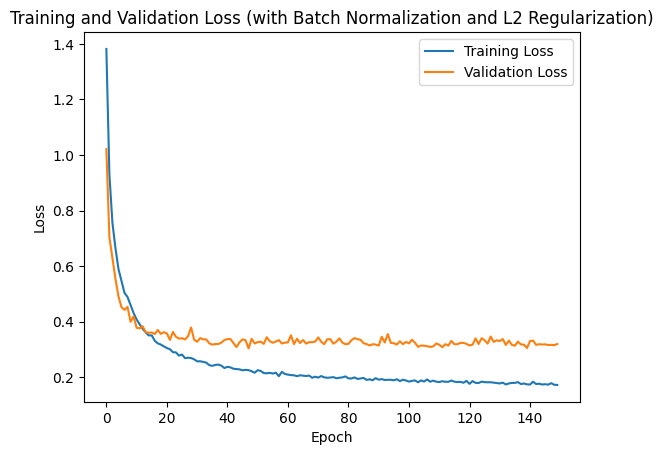

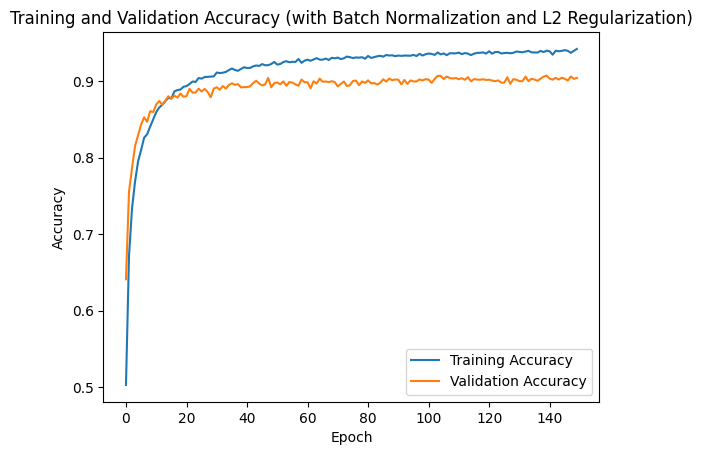

Test Accuracy for MiniVGG_dropout_1_BN model (with Batch Normalization and L2 Regularization): 0.9040


In [45]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_d1, test_loader)
print(f"Test Accuracy for MiniVGG_dropout_1_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

_____

____

_____

Method 2: In this method, the torch.dropout function is used directly within the forward method to apply dropout. This function allows for dropout to be applied to the input tensor with a specified dropout probability. This method does not require adding a separate dropout layer in the __init__ method.
(the torch.dropout function is used with the same dropout probability).

Applying dropout after each convolution layer

In [46]:
class MiniVGG_dropout_2(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(MiniVGG_dropout_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.dropout4 = nn.Dropout(dropout_prob)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.dropout5 = nn.Dropout(dropout_prob)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.dropout6 = nn.Dropout(dropout_prob)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout_fc1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.maxpool1(x)
        x = torch.relu(self.conv3(x))
        x = self.dropout3(x)
        x = torch.relu(self.conv4(x))
        x = self.dropout4(x)
        x = self.maxpool2(x)
        x = torch.relu(self.conv5(x))
        x = self.dropout5(x)
        x = torch.relu(self.conv6(x))
        x = self.dropout6(x)
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

In [47]:
# Initialize MiniVGG_dropout_2 model
model_dropout_2 = MiniVGG_dropout_2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_2.parameters(), lr=0.001)   # Experimenting with lr = 0.0001 (before tuning)  

# Train MiniVGG_dropout_2 model
train_losses_dropout_2, val_losses_dropout_2, train_accs_dropout_2, val_accs_dropout_2 = train(model_dropout_2, criterion, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 1.7202, Val Loss: 1.3703, Train Acc: 0.3608, Val Acc: 0.5060, Time: 8.44 seconds
Epoch 2/50, Train Loss: 1.2945, Val Loss: 1.1395, Train Acc: 0.5283, Val Acc: 0.5980, Time: 8.41 seconds
Epoch 3/50, Train Loss: 1.1159, Val Loss: 0.9563, Train Acc: 0.5962, Val Acc: 0.6597, Time: 8.37 seconds
Epoch 4/50, Train Loss: 1.0014, Val Loss: 0.8505, Train Acc: 0.6424, Val Acc: 0.7016, Time: 8.58 seconds
Epoch 5/50, Train Loss: 0.9160, Val Loss: 0.7941, Train Acc: 0.6768, Val Acc: 0.7228, Time: 8.34 seconds
Epoch 6/50, Train Loss: 0.8538, Val Loss: 0.7452, Train Acc: 0.6988, Val Acc: 0.7408, Time: 8.28 seconds
Epoch 7/50, Train Loss: 0.7981, Val Loss: 0.7169, Train Acc: 0.7172, Val Acc: 0.7488, Time: 8.39 seconds
Epoch 8/50, Train Loss: 0.7638, Val Loss: 0.6696, Train Acc: 0.7326, Val Acc: 0.7720, Time: 8.50 seconds
Epoch 9/50, Train Loss: 0.7263, Val Loss: 0.6410, Train Acc: 0.7463, Val Acc: 0.7766, Time: 8.40 seconds
Epoch 10/50, Train Loss: 0.6978, Val Loss: 0.6011, Trai

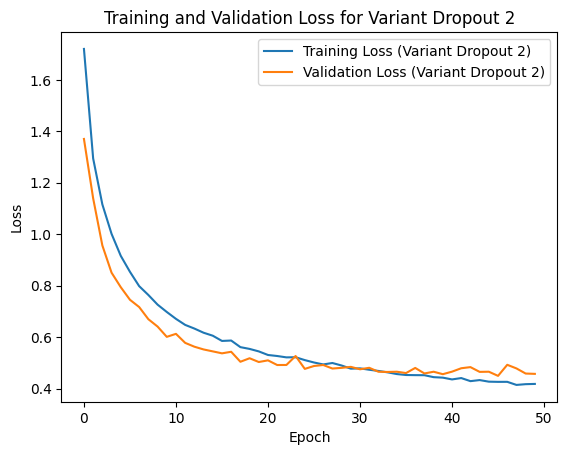

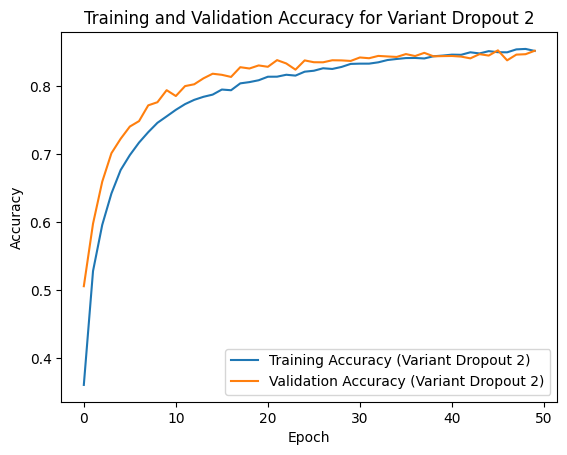

Test Accuracy for MiniVGG Dropout 2 model: 0.8523


In [48]:
# Plot training and validation loss for Variant 2b
plt.plot(train_losses_dropout_2, label='Training Loss (Variant Dropout 2)')
plt.plot(val_losses_dropout_2, label='Validation Loss (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 2')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 2b
plt.plot(train_accs_dropout_2, label='Training Accuracy (Variant Dropout 2)')
plt.plot(val_accs_dropout_2, label='Validation Accuracy (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 2')
plt.legend()
plt.show()

# Test the Variant Dropout 2 model
test_accuracy_dropout_2 = test(model_dropout_2, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 2 model: {test_accuracy_dropout_2:.4f}")

### Batch Normalization

In [124]:
import torch
import torch.nn as nn

class MiniVGG_dropout_2_BN(nn.Module):
    def __init__(self, dropout_prob=0.15):                     #### 0.2 gave good reuslts
        super(MiniVGG_dropout_2_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
        self.dropout1 = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.dropout2 = nn.Dropout(dropout_prob)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.dropout3 = nn.Dropout(dropout_prob)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
        self.dropout4 = nn.Dropout(dropout_prob)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
        self.dropout5 = nn.Dropout(dropout_prob)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
        self.dropout6 = nn.Dropout(dropout_prob)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)  # Batch normalization after fc1
        self.dropout_fc1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.maxpool1(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)
        x = self.maxpool2(x)
        x = torch.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        x = torch.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

In [100]:
# Initialize MiniVGG_dropout_2 model
model_dropout_2 = MiniVGG_dropout_2_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_2.parameters(), lr=0.0001)   # Experimenting with lr = 0.0001 (before tuning)  

# Train MiniVGG_dropout_2 model
train_losses_dropout_2, val_losses_dropout_2, train_accs_dropout_2, val_accs_dropout_2 = train(model_dropout_2, criterion, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 1.5527, Val Loss: 2.3349, Train Acc: 0.4385, Val Acc: 0.2545, Time: 7.96 seconds
Epoch 2/50, Train Loss: 1.2337, Val Loss: 1.7074, Train Acc: 0.5604, Val Acc: 0.4379, Time: 7.72 seconds
Epoch 3/50, Train Loss: 1.0733, Val Loss: 1.5559, Train Acc: 0.6207, Val Acc: 0.4730, Time: 7.69 seconds
Epoch 4/50, Train Loss: 0.9588, Val Loss: 1.1451, Train Acc: 0.6625, Val Acc: 0.6084, Time: 7.70 seconds
Epoch 5/50, Train Loss: 0.8797, Val Loss: 0.9447, Train Acc: 0.6901, Val Acc: 0.6713, Time: 7.68 seconds
Epoch 6/50, Train Loss: 0.8211, Val Loss: 0.9071, Train Acc: 0.7130, Val Acc: 0.6818, Time: 7.69 seconds
Epoch 7/50, Train Loss: 0.7721, Val Loss: 0.8886, Train Acc: 0.7292, Val Acc: 0.6941, Time: 7.73 seconds
Epoch 8/50, Train Loss: 0.7333, Val Loss: 0.8456, Train Acc: 0.7418, Val Acc: 0.7058, Time: 7.78 seconds
Epoch 9/50, Train Loss: 0.6949, Val Loss: 0.7603, Train Acc: 0.7577, Val Acc: 0.7332, Time: 7.70 seconds
Epoch 10/50, Train Loss: 0.6669, Val Loss: 0.7363, Trai

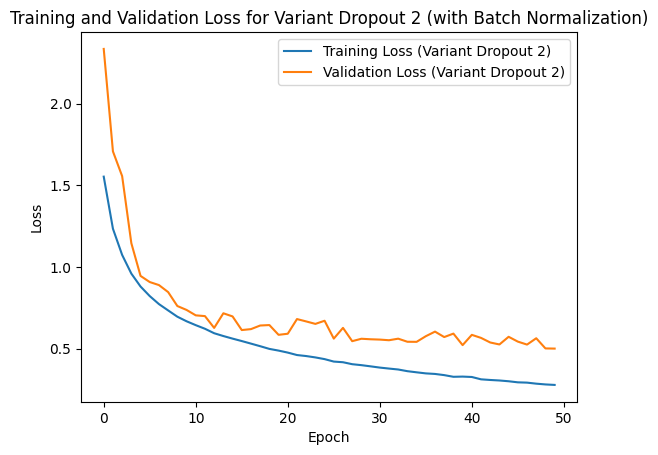

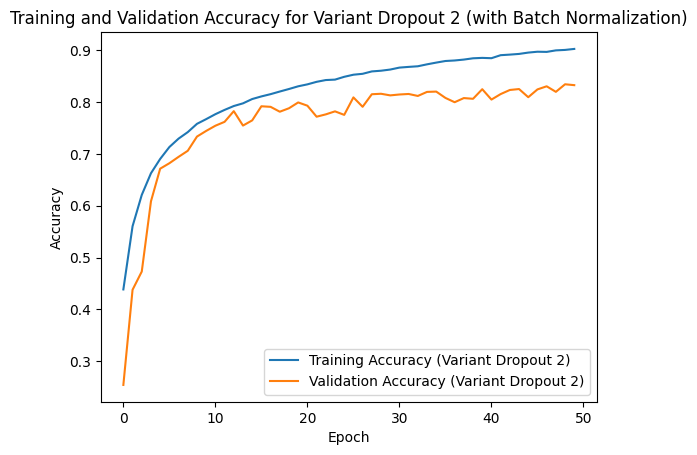

Test Accuracy for MiniVGG Dropout 2 model: 0.8323


In [101]:
# Plot training and validation loss for Variant 2b
plt.plot(train_losses_dropout_2, label='Training Loss (Variant Dropout 2)')
plt.plot(val_losses_dropout_2, label='Validation Loss (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 2 (with Batch Normalization)')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 2b
plt.plot(train_accs_dropout_2, label='Training Accuracy (Variant Dropout 2)')
plt.plot(val_accs_dropout_2, label='Validation Accuracy (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 2 (with Batch Normalization)')
plt.legend()
plt.show()

# Test the Variant Dropout 2 model
test_accuracy_dropout_2 = test(model_dropout_2, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 2 model: {test_accuracy_dropout_2:.4f}")

### Adding L2 regularization with weight decay of 1e-5

In [102]:
# Initialize MiniVGG_dropout_2 model
model_dropout_2 = MiniVGG_dropout_2_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_2.parameters(), lr=0.0001, weight_decay=1e-5)  # Adding weight decay  

# Train MiniVGG_dropout_2 model
train_losses_dropout_2, val_losses_dropout_2, train_accs_dropout_2, val_accs_dropout_2 = train(model_dropout_2, criterion, optimizer, train_loader, val_loader, num_epochs=70)

Epoch 1/70, Train Loss: 1.5676, Val Loss: 2.1665, Train Acc: 0.4335, Val Acc: 0.3110, Time: 7.69 seconds
Epoch 2/70, Train Loss: 1.2428, Val Loss: 1.7167, Train Acc: 0.5551, Val Acc: 0.4427, Time: 7.67 seconds
Epoch 3/70, Train Loss: 1.0842, Val Loss: 1.3447, Train Acc: 0.6151, Val Acc: 0.5380, Time: 7.71 seconds
Epoch 4/70, Train Loss: 0.9721, Val Loss: 1.2273, Train Acc: 0.6574, Val Acc: 0.5782, Time: 7.71 seconds
Epoch 5/70, Train Loss: 0.8920, Val Loss: 1.0064, Train Acc: 0.6873, Val Acc: 0.6566, Time: 7.69 seconds
Epoch 6/70, Train Loss: 0.8313, Val Loss: 0.9435, Train Acc: 0.7079, Val Acc: 0.6803, Time: 7.76 seconds
Epoch 7/70, Train Loss: 0.7815, Val Loss: 1.0251, Train Acc: 0.7280, Val Acc: 0.6527, Time: 7.68 seconds
Epoch 8/70, Train Loss: 0.7368, Val Loss: 0.7782, Train Acc: 0.7431, Val Acc: 0.7337, Time: 7.68 seconds
Epoch 9/70, Train Loss: 0.7014, Val Loss: 0.8437, Train Acc: 0.7556, Val Acc: 0.7104, Time: 7.70 seconds
Epoch 10/70, Train Loss: 0.6715, Val Loss: 0.7571, Trai

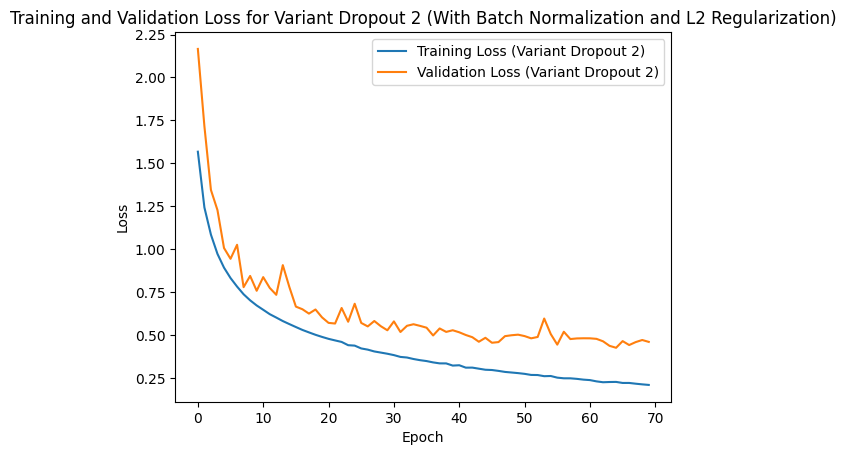

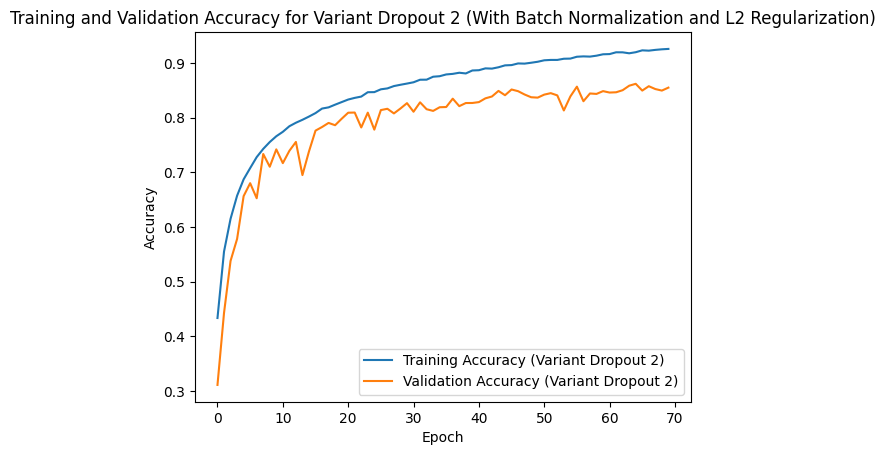

Test Accuracy for MiniVGG Dropout 2 model: 0.8552


In [103]:
# Plot training and validation loss for Variant 2b
plt.plot(train_losses_dropout_2, label='Training Loss (Variant Dropout 2)')
plt.plot(val_losses_dropout_2, label='Validation Loss (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 2 (With Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 2b
plt.plot(train_accs_dropout_2, label='Training Accuracy (Variant Dropout 2)')
plt.plot(val_accs_dropout_2, label='Validation Accuracy (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 2 (With Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the Variant Dropout 2 model
test_accuracy_dropout_2 = test(model_dropout_2, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 2 model: {test_accuracy_dropout_2:.4f}")

### Adding L2 regularization with weight decay of 1e-4

In [104]:
# Initialize MiniVGG_dropout_2 model
model_dropout_2 = MiniVGG_dropout_2_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_2.parameters(), lr=0.0001, weight_decay=1e-4)  # Adding weight decay  

# Train MiniVGG_dropout_2 model
train_losses_dropout_2, val_losses_dropout_2, train_accs_dropout_2, val_accs_dropout_2 = train(model_dropout_2, criterion, optimizer, train_loader, val_loader, num_epochs=70)

Epoch 1/70, Train Loss: 1.5465, Val Loss: 1.5795, Train Acc: 0.4420, Val Acc: 0.4212, Time: 7.67 seconds
Epoch 2/70, Train Loss: 1.2197, Val Loss: 1.3509, Train Acc: 0.5620, Val Acc: 0.5202, Time: 7.70 seconds
Epoch 3/70, Train Loss: 1.0596, Val Loss: 1.1321, Train Acc: 0.6267, Val Acc: 0.5997, Time: 7.66 seconds
Epoch 4/70, Train Loss: 0.9478, Val Loss: 0.9928, Train Acc: 0.6663, Val Acc: 0.6598, Time: 7.70 seconds
Epoch 5/70, Train Loss: 0.8690, Val Loss: 0.9135, Train Acc: 0.6953, Val Acc: 0.6873, Time: 7.69 seconds
Epoch 6/70, Train Loss: 0.8104, Val Loss: 0.7951, Train Acc: 0.7173, Val Acc: 0.7300, Time: 7.69 seconds
Epoch 7/70, Train Loss: 0.7666, Val Loss: 0.7573, Train Acc: 0.7299, Val Acc: 0.7405, Time: 7.75 seconds
Epoch 8/70, Train Loss: 0.7229, Val Loss: 0.7043, Train Acc: 0.7471, Val Acc: 0.7562, Time: 7.70 seconds
Epoch 9/70, Train Loss: 0.6981, Val Loss: 0.6957, Train Acc: 0.7574, Val Acc: 0.7623, Time: 7.67 seconds
Epoch 10/70, Train Loss: 0.6660, Val Loss: 0.6551, Trai

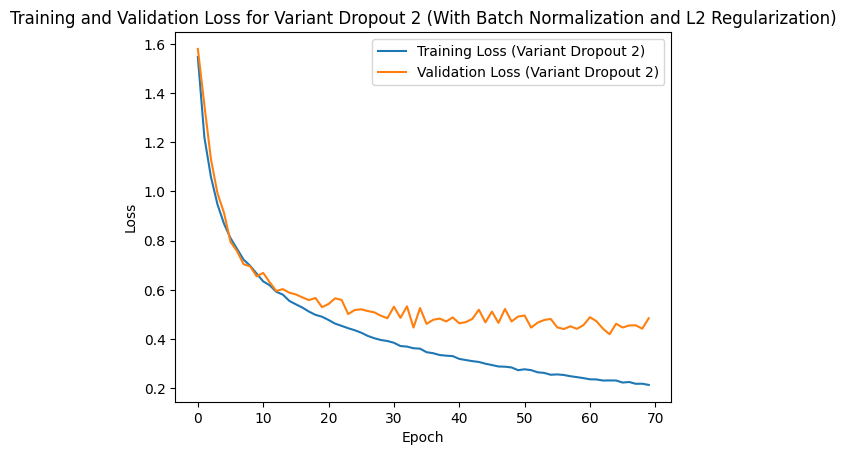

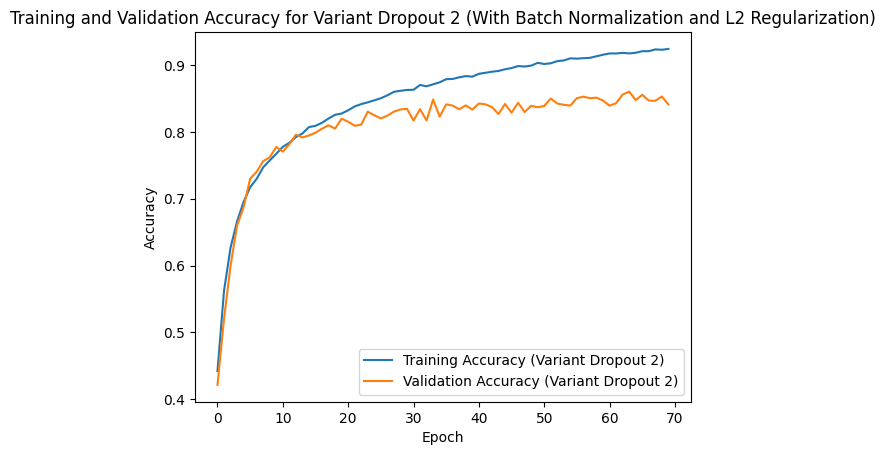

Test Accuracy for MiniVGG Dropout 2 model: 0.8413


In [105]:
# Plot training and validation loss for Variant 2b
plt.plot(train_losses_dropout_2, label='Training Loss (Variant Dropout 2)')
plt.plot(val_losses_dropout_2, label='Validation Loss (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 2 (With Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 2b
plt.plot(train_accs_dropout_2, label='Training Accuracy (Variant Dropout 2)')
plt.plot(val_accs_dropout_2, label='Validation Accuracy (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 2 (With Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the Variant Dropout 2 model
test_accuracy_dropout_2 = test(model_dropout_2, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 2 model: {test_accuracy_dropout_2:.4f}")

### Changing L2 regularization with weight decay of 1e-3

In [126]:
# Initialize MiniVGG_dropout_2 model
model_dropout_2 = MiniVGG_dropout_2_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout_2.parameters(), lr=0.0001, weight_decay=1e-3)  # Adding weight decay  #0.0001 & 1e-3 gave better results

# Train MiniVGG_dropout_2 model
train_losses_dropout_2, val_losses_dropout_2, train_accs_dropout_2, val_accs_dropout_2 = train(model_dropout_2, criterion, optimizer, train_loader, val_loader, num_epochs=140)

Epoch 1/140, Train Loss: 1.5002, Val Loss: 1.7963, Train Acc: 0.4583, Val Acc: 0.4167, Time: 7.64 seconds
Epoch 2/140, Train Loss: 1.1790, Val Loss: 1.3158, Train Acc: 0.5804, Val Acc: 0.5422, Time: 7.60 seconds
Epoch 3/140, Train Loss: 1.0164, Val Loss: 1.0789, Train Acc: 0.6415, Val Acc: 0.6268, Time: 7.59 seconds
Epoch 4/140, Train Loss: 0.9083, Val Loss: 0.9623, Train Acc: 0.6824, Val Acc: 0.6712, Time: 7.59 seconds
Epoch 5/140, Train Loss: 0.8306, Val Loss: 0.8033, Train Acc: 0.7097, Val Acc: 0.7289, Time: 7.56 seconds
Epoch 6/140, Train Loss: 0.7707, Val Loss: 0.7640, Train Acc: 0.7332, Val Acc: 0.7417, Time: 7.60 seconds
Epoch 7/140, Train Loss: 0.7257, Val Loss: 0.7568, Train Acc: 0.7479, Val Acc: 0.7418, Time: 7.65 seconds
Epoch 8/140, Train Loss: 0.6920, Val Loss: 0.6560, Train Acc: 0.7602, Val Acc: 0.7786, Time: 7.66 seconds
Epoch 9/140, Train Loss: 0.6620, Val Loss: 0.6091, Train Acc: 0.7689, Val Acc: 0.7926, Time: 7.58 seconds
Epoch 10/140, Train Loss: 0.6303, Val Loss: 0.

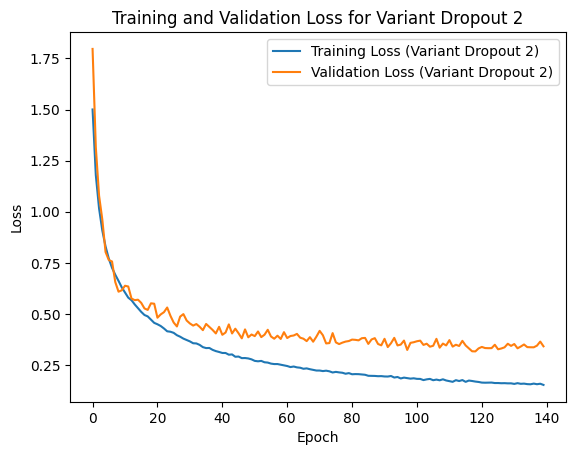

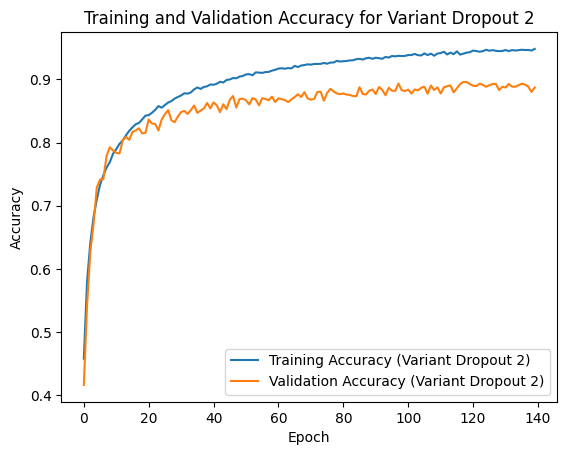

Test Accuracy for MiniVGG Dropout 2 model: 0.8870


In [127]:
# Plot training and validation loss for Variant 2b
plt.plot(train_losses_dropout_2, label='Training Loss (Variant Dropout 2)')
plt.plot(val_losses_dropout_2, label='Validation Loss (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant Dropout 2')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 2b
plt.plot(train_accs_dropout_2, label='Training Accuracy (Variant Dropout 2)')
plt.plot(val_accs_dropout_2, label='Validation Accuracy (Variant Dropout 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant Dropout 2')
plt.legend()
plt.show()

# Test the Variant Dropout 2 model
test_accuracy_dropout_2 = test(model_dropout_2, test_loader)
print(f"Test Accuracy for MiniVGG Dropout 2 model: {test_accuracy_dropout_2:.4f}")